In [42]:
import matplotlib.pyplot as plt
import config
import pandas as pd
import download_files
import numpy as np

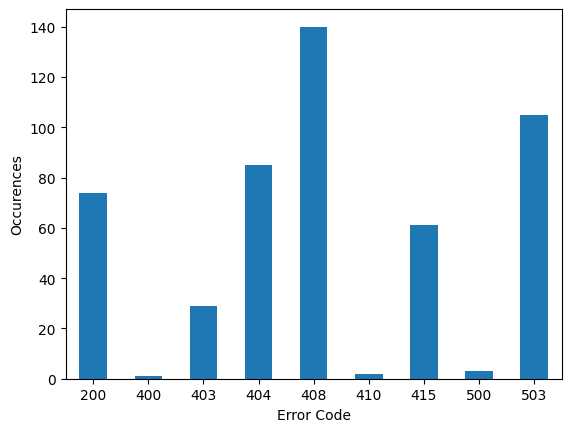

In [2]:
df = pd.read_json(config.LOG_FILE, orient="index")
df.columns = ["success", "status code", "url"]
counts = df["status code"].value_counts().sort_index()

counts.plot(kind='bar')

plt.xlabel("Error Code")
plt.ylabel("Occurences")
plt.xticks(rotation=0)
plt.show()

In [11]:
df_iterrows = pd.read_json("benchmarks/benchmarks_iterrows.json", orient="index")
df = pd.DataFrame.from_dict(df_iterrows["download_status"].to_dict())

df_stacked = df.stack().reset_index()
df_stacked.columns = ["id", "run", "values"]

# Step 2: split the list into columns
df_expanded = pd.DataFrame(df_stacked["values"].tolist(), columns=["success", "status_code", "url"])

# Step 3: combine with index columns
df_final = pd.concat([df_stacked[["id", "run"]], df_expanded], axis=1)

df_iterrows["elapsed_time"].mean()

np.float64(75.08709767999899)

In [13]:
df_vectorization = pd.read_json("benchmarks/benchmarks_pandas_vectorization.json", orient="index")
df = pd.DataFrame.from_dict(df_vectorization["download_status"].to_dict())

df_stacked = df.stack().reset_index()
df_stacked.columns = ["id", "run", "values"]

# Step 2: split the list into columns
df_expanded = pd.DataFrame(df_stacked["values"].tolist(), columns=["success", "status_code", "url"])

# Step 3: combine with index columns
df_final = pd.concat([df_stacked[["id", "run"]], df_expanded], axis=1)

df_vectorization["elapsed_time"].mean()

np.float64(58.72271329999785)

In [34]:
df_sequential = pd.read_json("benchmarks/benchmarks_sequential.json", orient="index")
df_sequential_download = pd.DataFrame.from_dict(df_sequential["download_status"].to_dict())

df_stacked = df_sequential_download.stack().reset_index()
df_stacked.columns = ["id", "run", "values"]

# Step 2: split the list into columns
df_expanded = pd.DataFrame(df_stacked["values"].tolist(), columns=["success", "status_code", "url"])

# Step 3: combine with index columns
df_final = pd.concat([df_stacked[["id", "run"]], df_expanded], axis=1)

df_final["success"].sum() / 500

np.float64(0.186)

In [ ]:
print(df_sequential["elapsed_time"].mean())
print(df_vectorization["elapsed_time"].mean())
print(df_iterrows["elapsed_time"].mean())

1002.3306551999995
58.72271329999785
75.08709767999899


In [43]:
means = [
    np.mean(df_sequential["elapsed_time"]),
    np.mean(df_iterrows["elapsed_time"]),
    np.mean(df_vectorization["elapsed_time"])
]

std_devs = [
    np.std(df_sequential["elapsed_time"]),
    np.std(df_iterrows["elapsed_time"]),
    np.std(df_vectorization["elapsed_time"])
]

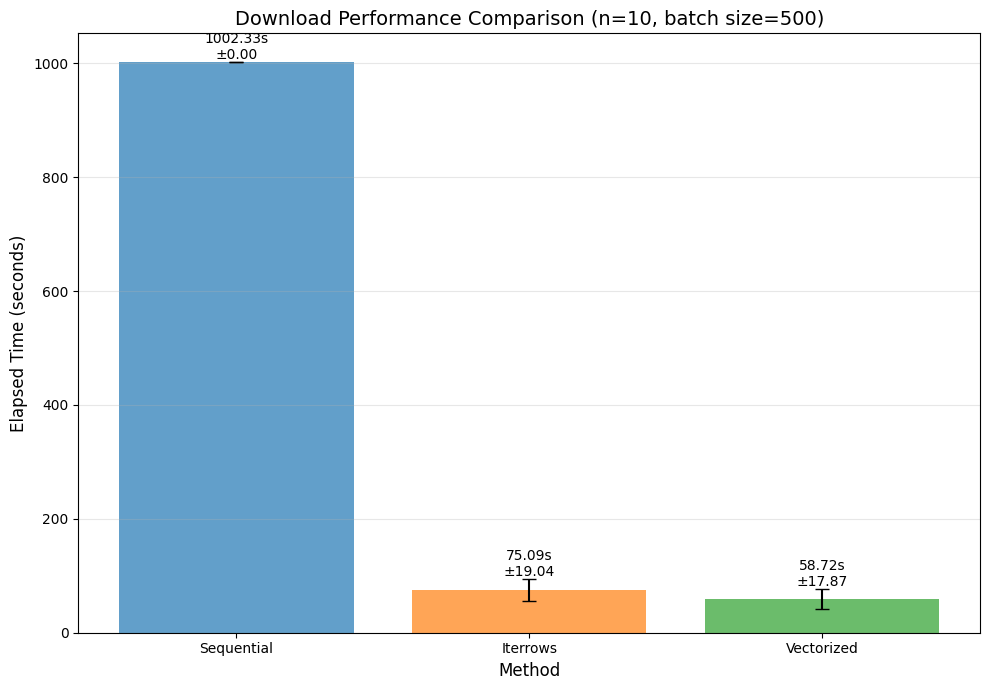

In [51]:
methods = ['Sequential', 'Iterrows', 'Vectorized']
x = np.arange(len(methods))
fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.bar(x, means, yerr=std_devs, capsize=5, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Elapsed Time (seconds)', fontsize=12)
ax.set_title('Download Performance Comparison (n=10, batch size=500)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, std_devs)):
    ax.text(i, mean + std, f'{mean:.2f}s\n±{std:.2f}', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()